**Public LB: 85.9335 (6th rank)**

**Private LB: 86.3685 (7th rank)**

Link to LB: https://datahack.analyticsvidhya.com/contest/janatahack-cross-sell-prediction/#LeaderBoard

# **Key takeaways which helped :**

**1) when class imbalance is taken into account different set of prediction probabilities are predicted where as when we don't take class imbalance into account different prediction probabilities are predicted but LB score and my cv score were giving same ROC AUC score in both the cases.**

**2) when we take mean or provide weights while blending gives the values between two extremes so i have blended predictions of Catboost and Lightgbm which pushed my score 0.8588 to 0.8593 in public LB** 

**3) Creating Rank Features boosted my LGBM score. Thanks to @Anil who introduced me to such features**

   reference link:https://github.com/AnilBetta/AV-Janata-Hack-healh-Care-2
   
**4) Creating different set of features for different models really helped in pushing the score.**



# **Problem Statement**



Your client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.

An insurance policy is an arrangement by which a company undertakes to provide a guarantee of compensation for specified loss, damage, illness, or death in return for the payment of a specified premium. A premium is a sum of money that the customer needs to pay regularly to an insurance company for this guarantee.

For example, you may pay a premium of Rs. 5000 each year for a health insurance cover of Rs. 200,000/- so that if, God forbid, you fall ill and need to be hospitalised in that year, the insurance provider company will bear the cost of hospitalisation etc. for upto Rs. 200,000. Now if you are wondering how can company bear such high hospitalisation cost when it charges a premium of only Rs. 5000/-, that is where the concept of probabilities comes in picture. For example, like you, there may be 100 customers who would be paying a premium of Rs. 5000 every year, but only a few of them (say 2-3) would get hospitalised that year and not everyone. This way everyone shares the risk of everyone else.

Just like medical insurance, there is vehicle insurance where every year customer needs to pay a premium of certain amount to insurance provider company so that in case of unfortunate accident by the vehicle, the insurance provider company will provide a compensation (called ‘sum assured’) to the customer.

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue. 

Now, in order to predict, whether the customer would be interested in Vehicle insurance, you have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) etc.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold,StratifiedKFold,train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import os
import eli5
from eli5.sklearn import PermutationImportance
from catboost import CatBoostClassifier

from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint


In [2]:
train_df=pd.read_csv('../input/av-janatahack-crosssell-prediction/train.csv')
test_df=pd.read_csv('../input/av-janatahack-crosssell-prediction/test.csv')
submission_df=pd.read_csv('../input/av-janatahack-crosssell-prediction/sample.csv')

# **Basic EDA**

In [3]:
train_df.head(5)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


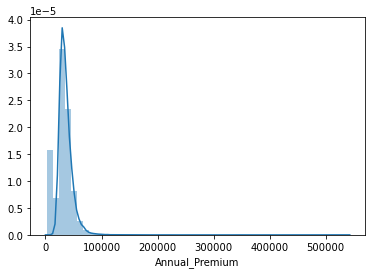

In [4]:
sns.distplot(train_df['Annual_Premium'])

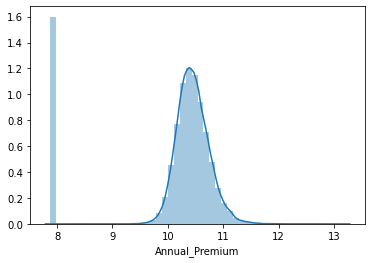

In [5]:
train_df['Annual_Premium']=np.log(train_df['Annual_Premium'])
sns.distplot(train_df['Annual_Premium'])

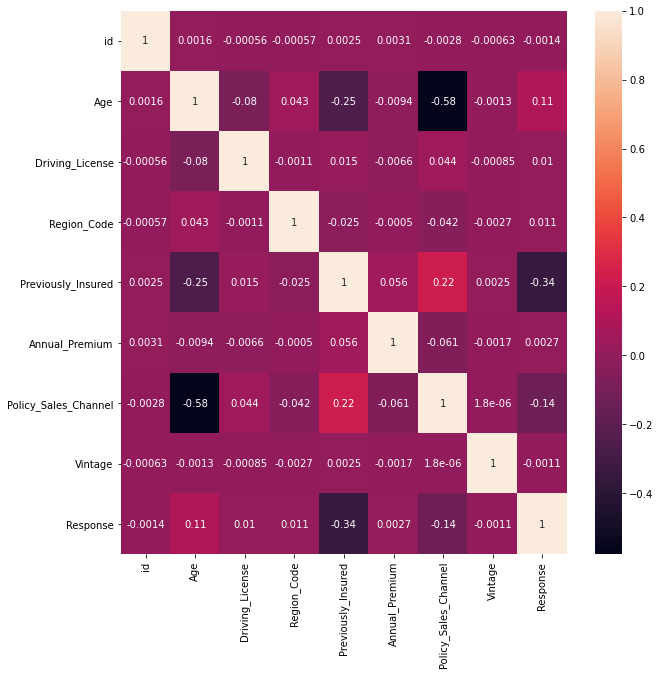

In [6]:
plt.figure(figsize=(10,10))
sns.heatmap(train_df.corr(),annot=True)

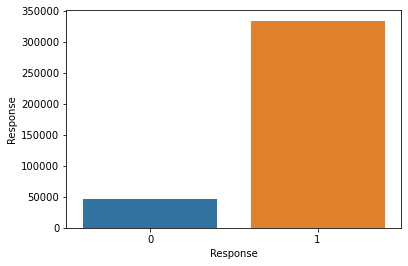

In [7]:
sns.barplot(train_df['Response'],train_df['Response'].value_counts())

# **Adding Features for LGBM**

In [8]:
train_df=train_df.drop_duplicates(subset=[ele for ele in list(train_df.columns) if ele not in ['id']])
combine_set=pd.concat([train_df,test_df])
le=LabelEncoder()
combine_set['Gender']=le.fit_transform(combine_set['Gender'])
combine_set['Vehicle_Damage']=le.fit_transform(combine_set['Vehicle_Damage'])
combine_set['Vehicle_Age']=combine_set['Vehicle_Age'].map({'< 1 Year':0,'1-2 Year':1,'> 2 Years':2})
# df=pd.get_dummies(combine_set['Vehicle_Age'],drop_first=True)
# combine_set=pd.concat([combine_set,df],axis=1)

# fe=combine_set.groupby('Vehicle_Age').size()/len(combine_set)
# combine_set['Vehicle_Age']=combine_set['Vehicle_Age'].apply(lambda x: fe[x])
combine_set['Customer_term_in_year']=combine_set['Vintage']/365
combine_set['Total_premium_Channelwise']=combine_set.groupby(['Policy_Sales_Channel'])['Annual_Premium'].transform('sum')
combine_set['Mean_premium_Channelwise']=combine_set.groupby(['Policy_Sales_Channel'])['Annual_Premium'].transform('mean')
combine_set['Maximum_premium_Channelwise']=combine_set.groupby(['Policy_Sales_Channel'])['Annual_Premium'].transform('max')
combine_set['Min_premium_Channelwise']=combine_set.groupby(['Policy_Sales_Channel'])['Annual_Premium'].transform('min')
combine_set['Total_premium_regionwise']=combine_set.groupby(['Region_Code'])['Annual_Premium'].transform('sum')
combine_set['Mean_premium_regionwise']=combine_set.groupby(['Region_Code'])['Annual_Premium'].transform('mean')
combine_set['Max_premium_regionwise']=combine_set.groupby(['Region_Code'])['Annual_Premium'].transform('max')
combine_set['Min_premium_regionwise']=combine_set.groupby(['Region_Code'])['Annual_Premium'].transform('min')
combine_set['Age_groups_region_wise']=combine_set.groupby(['Region_Code'])['Age'].transform('nunique')
combine_set['regionwise_channels']=combine_set.groupby(['Policy_Sales_Channel'])['Region_Code'].transform('nunique')
combine_set['Channelwise_regions']=combine_set.groupby(['Region_Code'])['Policy_Sales_Channel'].transform('nunique')
combine_set['Unique_customers_based_Vinatge']=combine_set.groupby(['Region_Code','Policy_Sales_Channel'])['Vintage'].transform('nunique')
combine_set['Region_wise_Vehicle_Age_premium']=combine_set.groupby(['Region_Code','Vehicle_Age'])['Annual_Premium'].transform('sum')
combine_set['Region_wise_Vehicle_Age_premium_mean']=combine_set.groupby(['Region_Code','Vehicle_Age'])['Annual_Premium'].transform('mean')
combine_set['Region_wise_Vehicle_Age_premium_max']=combine_set.groupby(['Region_Code','Vehicle_Age'])['Annual_Premium'].transform('max')
combine_set['Channel_wise_Vehicle_Age_premium']=combine_set.groupby(['Policy_Sales_Channel', 'Vehicle_Age'])['Annual_Premium'].transform('sum')
combine_set['Channel_wise_Vehicle_Age_premium_mean']=combine_set.groupby(['Policy_Sales_Channel', 'Vehicle_Age'])['Annual_Premium'].transform('mean')
combine_set['Channel_wise_Vehicle_Age_premium_max']=combine_set.groupby(['Policy_Sales_Channel', 'Vehicle_Age'])['Annual_Premium'].transform('max')

#Rank Features
combine_set['Rank_regionwise_premium']=combine_set.groupby(['Region_Code'])['Annual_Premium'].rank(method='first',ascending=True)
combine_set['Rank_mean_regionwise_premium']=combine_set.groupby(['Region_Code'])['Annual_Premium'].rank(method='average',ascending=True)
combine_set['Rank_max_regionwise_premium']=combine_set.groupby(['Region_Code'])['Annual_Premium'].rank(method='max',ascending=True)
combine_set['Rank_min_regionwise_premium']=combine_set.groupby(['Region_Code'])['Annual_Premium'].rank(method='min',ascending=True)
combine_set['Rank_regionwise_diff']=combine_set['Rank_max_regionwise_premium']- combine_set['Rank_min_regionwise_premium']
combine_set['Rank_channelwise_premium']=combine_set.groupby(['Policy_Sales_Channel'])['Annual_Premium'].rank(method='first',ascending=True)
combine_set['Rank_mean_channelwise_premium']=combine_set.groupby(['Policy_Sales_Channel'])['Annual_Premium'].rank(method='average',ascending=True)
combine_set['Rank_max_channelwise_premium']=combine_set.groupby(['Policy_Sales_Channel'])['Annual_Premium'].rank(method='max',ascending=True)
combine_set['Rank_min_channelwise_premium']=combine_set.groupby(['Policy_Sales_Channel'])['Annual_Premium'].rank(method='min',ascending=True)
combine_set['Rank_channelwise_diff']=combine_set['Rank_max_channelwise_premium']- combine_set['Rank_min_channelwise_premium']
combine_set['Rank_Channel_wise_Vehicle_Age_Premium']=combine_set.groupby(['Policy_Sales_Channel','Vehicle_Age'])['Annual_Premium'].rank(method='first',ascending=True)
combine_set['Rank_Region_wise_Vehicle_Age_premium']=combine_set.groupby(['Region_Code','Vehicle_Age'])['Annual_Premium'].rank(method='first',ascending=True)
combine_set['Rank_Age_wise_premium']=combine_set.groupby(['Age'])['Annual_Premium'].rank(method='first',ascending=True)

combine_set.head(5)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,...,Rank_min_regionwise_premium,Rank_regionwise_diff,Rank_channelwise_premium,Rank_mean_channelwise_premium,Rank_max_channelwise_premium,Rank_min_channelwise_premium,Rank_channelwise_diff,Rank_Channel_wise_Vehicle_Age_Premium,Rank_Region_wise_Vehicle_Age_premium,Rank_Age_wise_premium
0,1,1,44,1,28.0,0,2,1,10.607921,26.0,...,59233.0,5.0,54268.0,54269.0,54270.0,54268.0,2.0,3771.0,4320.0,6187.0
1,2,1,76,1,3.0,0,1,0,10.420375,26.0,...,7150.0,1.0,36846.0,36848.0,36850.0,36846.0,4.0,31750.0,3554.0,637.0
2,3,1,47,1,28.0,0,2,1,10.553049,26.0,...,51635.0,1.0,49394.0,49396.5,49399.0,49394.0,5.0,3313.0,3694.0,4905.0
3,4,1,21,1,11.0,1,0,0,10.261826,152.0,...,4383.0,0.0,53337.0,53339.5,53342.0,53337.0,5.0,49160.0,2519.0,6419.0
4,5,0,29,1,41.0,1,0,0,10.221796,152.0,...,5920.0,1.0,46026.0,46028.5,46031.0,46026.0,5.0,42321.0,3041.0,3049.0


# **Adding Features for Catboost**

In [9]:
cat_cols = train_df.select_dtypes(include = 'object')
num_cols = train_df.select_dtypes(include=['int64','float64'])
combine=pd.concat([train_df,test_df])
combine['Vintage'] = combine['Vintage']/365
combine['Vehicle_Age']=combine['Vehicle_Age'].replace({'< 1 Year':0,'1-2 Year':1,'> 2 Years':2})
combine['Vehicle_Damage']=combine['Vehicle_Damage'].replace({'Yes':1,'No':0})
combine['Gender']=combine['Gender'].replace({'Male':1,'Female':0})
combine['IsPreviouslyInsuredandVehicleDamaged'] = np.where((combine['Previously_Insured']==0) & (combine['Vehicle_Damage']==1),1,0)
combine['IsVehicleDamagedandDrivingLicense'] = np.where((combine['Vehicle_Damage']==1) & (combine['Driving_License']==1),1,0)
combine['TotalAmountPaidTillDate'] = combine['Annual_Premium']*combine['Vintage']
combine['PremiumperRegion'] = combine.groupby('Region_Code')['Annual_Premium'].transform('mean')
combine['PremiumperPolicy_Sales_Channel'] = combine.groupby('Policy_Sales_Channel')['Annual_Premium'].transform('mean')
combine['AvgVehicleAgePerRegion'] = combine.groupby('Policy_Sales_Channel')['Annual_Premium'].transform('mean')
combine['AvgCustomerAgeRegionWise'] = combine.groupby('Region_Code')['Age'].transform('mean')
combine['AvgCustomerAgeSaleChannelWise'] = combine.groupby('Policy_Sales_Channel')['Age'].transform('mean')
combine['SaleChannelsPerRegion'] = combine.groupby('Region_Code')['Policy_Sales_Channel'].transform('nunique')
combine['RegionwisePreviouslyInsured'] = combine.groupby('Region_Code')['Previously_Insured'].transform('count')
combine['RegionwiseVintage'] = combine.groupby('Region_Code')['Vintage'].transform('mean').astype('int')
combine['SaleChannelwiseVintage'] = combine.groupby('Policy_Sales_Channel')['Vintage'].transform('mean').astype('int')
combine['AvgRegionGenderWisePremium'] = combine.groupby(['Region_Code','Gender'])['Annual_Premium'].transform('mean')
combine['NoPeoplePrevInsuredRegionGenderWise'] = combine.groupby(['Region_Code','Gender'])['Previously_Insured'].transform('count')
combine['NoPeoplePrevInsuredSalesChannelGenderWise'] = combine.groupby(['Policy_Sales_Channel','Gender'])['Previously_Insured'].transform('count')
combine['NoPeoplePrevInsuredSalesChannelRegionWise'] = combine.groupby(['Region_Code','Policy_Sales_Channel'])['Previously_Insured'].transform('count')
combine['AvgCustomerDurationRegionGenderWise'] = combine.groupby(['Region_Code','Gender'])['Vintage'].transform('mean')
combine['InsuranceLicense'] = combine['Driving_License'].astype('str') + '' + combine['Previously_Insured'].astype('str')
combine['InsuranceGender'] = combine['Gender'].astype('str') + '' + combine['Previously_Insured'].astype('str')
combine['Region_Code']=combine['Region_Code'].astype(int)
combine['Policy_Sales_Channel']=combine['Policy_Sales_Channel'].astype(int)
combine.head(5)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,...,RegionwisePreviouslyInsured,RegionwiseVintage,SaleChannelwiseVintage,AvgRegionGenderWisePremium,NoPeoplePrevInsuredRegionGenderWise,NoPeoplePrevInsuredSalesChannelGenderWise,NoPeoplePrevInsuredSalesChannelRegionWise,AvgCustomerDurationRegionGenderWise,InsuranceLicense,InsuranceGender
0,1,1,44,1,28,0,2,1,10.607921,26,...,141857,0,0,9631.001984,80081,65588,50085,0.422864,10,10
1,2,1,76,1,3,0,1,0,10.420375,26,...,12343,0,0,6115.621828,6875,65588,2240,0.424436,10,10
2,3,1,47,1,28,0,2,1,10.553049,26,...,141857,0,0,9631.001984,80081,65588,50085,0.422864,10,10
3,4,1,21,1,11,1,0,0,10.261826,152,...,12325,0,0,6720.150971,6178,77555,6732,0.422356,11,11
4,5,0,29,1,41,1,0,0,10.221796,152,...,24393,0,0,8033.998890,11425,101864,11498,0.424287,11,01


# **Loading Data....(LGBM)**

In [10]:
train_df=combine_set[combine_set['Response'].isnull()==False]
test_df=combine_set[combine_set['Response'].isnull()==True]
X=train_df.drop(['id','Response'],axis=1)
y=train_df['Response'] 
X_main_test=test_df.drop(['id','Response'],axis=1)


# **Loading Data....(Catboost)**

In [11]:
cat_col=['Gender','Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage','Policy_Sales_Channel', 'InsuranceLicense','InsuranceGender']
train = combine[combine['Response'].isnull()!= True]
test = combine[combine['Response'].isnull()== True]
test=test.drop(['id','Response'],axis=1)
X_cat = train.drop(['id',"Response"], axis=1)
Y = train["Response"]

In [12]:
# #Check for Permutation Importance of Features
# perm = PermutationImportance(lg,random_state=294).fit(X_val, y_val)
# eli5.show_weights(perm,feature_names=X_val.columns.tolist())


# **KFold (LGBM)**

In [13]:
#Kfold
kf=StratifiedKFold(n_splits=10,shuffle=True,random_state=294)
pred_score=0
preds=0

for i, (train_idx,val_idx) in enumerate(kf.split(X,y)):
    X_train,y_train=X.iloc[train_idx,:],y.iloc[train_idx]
    X_val,y_val=X.iloc[val_idx,:],y.iloc[val_idx]
    
    print('\nFold: {}\n'.format(i+1))
    
    lg=LGBMClassifier(boosting_type='gbdt',n_estimators=500,depth=10,learning_rate=0.04,objective='binary',metric='auc',
                 colsample_bytree=0.5,reg_lambda=2,reg_alpha=2,random_state=294,n_jobs=-1)      
   

    lg.fit(X_train,y_train)
    print(roc_auc_score(y_val,lg.predict_proba(X_val)[:,1]))
    
    pred_score+=roc_auc_score(y_val,lg.predict_proba(X_val)[:,1])
    
    preds+=lg.predict_proba(X_main_test)[:,1]
    
print('mean_score: {}'.format(pred_score/10))

preds_lg=preds/10

    


Fold: 1

0.860836584337104

Fold: 2

0.8562975486242043

Fold: 3

0.8566145605506816

Fold: 4

0.859856522434578

Fold: 5

0.8591829766483126

Fold: 6

0.8609477448370201

Fold: 7

0.8592914315428329

Fold: 8

0.8577529910910916

Fold: 9

0.8585657729499221

Fold: 10

0.8586601564880023
mean_score: 0.8588006289503749


# **KFold (Catboost)**

In [14]:
kf=StratifiedKFold(n_splits=5,shuffle=True,random_state=294)
predictions=[]
test_roc_score=[]

    
for i,(train_idx,val_idx) in enumerate(kf.split(X_cat,Y)):    

    X_train, y_train = X_cat.iloc[train_idx,:], Y.iloc[train_idx]

    X_val, y_val = X_cat.iloc[val_idx, :], Y.iloc[val_idx]
    

    print('\nFold: {}\n'.format(i+1))

    classifier = CatBoostClassifier(learning_rate = 0.055,random_state=42,scale_pos_weight=7, custom_metric=['AUC'])

    classifier.fit(X_train,y_train,cat_features=cat_col,eval_set=(X_val, y_val),early_stopping_rounds=30,verbose=100)
    
    testpred = classifier.predict_proba(X_val)[:,1]
    test_roc_score.append(roc_auc_score(y_val, testpred))
    print("Test ROC AUC : %.4f"%(roc_auc_score(y_val, testpred)))
    predictions.append(classifier.predict_proba(test)[:,1])

print("Mean test score:",np.mean(test_roc_score))
preds_cb=np.mean(predictions,axis=0)


Fold: 1

0:	learn: 0.6481814	test: 0.6483084	best: 0.6483084 (0)	total: 508ms	remaining: 8m 27s
100:	learn: 0.4202536	test: 0.4201356	best: 0.4201356 (100)	total: 31.1s	remaining: 4m 36s
200:	learn: 0.4173929	test: 0.4188417	best: 0.4188358 (199)	total: 1m 1s	remaining: 4m 3s
300:	learn: 0.4147912	test: 0.4183594	best: 0.4183356 (298)	total: 1m 32s	remaining: 3m 34s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4182746875
bestIteration = 336

Shrink model to first 337 iterations.
Test ROC AUC : 0.8588

Fold: 2

0:	learn: 0.6481023	test: 0.6483166	best: 0.6483166 (0)	total: 364ms	remaining: 6m 3s
100:	learn: 0.4196996	test: 0.4219979	best: 0.4219979 (100)	total: 31.3s	remaining: 4m 38s
200:	learn: 0.4168768	test: 0.4207410	best: 0.4207410 (200)	total: 1m 1s	remaining: 4m 3s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4204972404
bestIteration = 245

Shrink model to first 246 iterations.
Test ROC AUC : 0.8582

Fold: 3

0:	learn: 0.6477042	tes

In [15]:
#Submission File
submission_df['Response']=preds_lg*0.6+preds_cb*0.4
submission_df.to_csv('main_test.csv',index=False)
submission_df.head(5)
# np.array(lg.predict_proba(X_main_test)[:,1])

,id,Response
0,381110,0.001311
1,381111,0.476620
2,381112,0.506983
3,381113,0.014627
4,381114,0.001286


# **If you like the notebook please upvote**

# **Thank You :)**